In [6]:
import numpy as np
import pandas as pd
import random
import os.path
import math
from scipy.sparse.linalg import eigs

from collections import defaultdict
import matplotlib.pyplot as plt

In [7]:
def n_cross_val(A, n):
    for i in range(0, len(A), n):
        yield (A[:i]+A[i+n:], A[i:i + n])

In [8]:
class FLDA_2class:
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.obs, self.n = X.shape
        assert(self.obs==y.shape[0])
        assert(len(np.unique(y))==2), "This is only for 2-class Fischer Discriminants projections"
    
    def build(self):
        self.Xeach = self._split_by_class(self.X, self.y)
        self._compute_all_mean()
        scatter=self._calculate_within_class_scatter()
        self.w = np.dot(np.linalg.inv(scatter), (self.mueach[0].T - self.mueach[1].T))
        return self
    
    def linear_discriminant(self):
        return self.w
    
    def predict(self, Xt, Yt):
        Zt = Xt.dot(self.w)
        z0=self.threshold()
        
        #f=np.vectorize(lambda x: 0 if all(np.dot(x, self.w)<z0.reshape(1,1)) else 1)
        #pred=f(Zt)
        Y0 = Zt[np.where(Yt==0)]
        Y1 = Zt[np.where(Yt==1)]
        return (Y0, Y1)
        
    def threshold(self):
        mu1 = np.dot(self.Xeach[0], self.w).mean(axis=0)
        mu2 = np.dot(self.Xeach[1], self.w).mean(axis=0)
        return (mu1+mu2)/2
    
    def _calculate_within_class_scatter(self):
        Sw = np.zeros((self.n, self.n))
        df={}
        for c in [0,1]:
            df[c] = self.Xeach[c] - np.array(list(self.mueach[c])*(self.Xeach[c].shape[0])).reshape(self.Xeach[c].shape)
        diff = np.concatenate([df[0], df[1]])
        diff=np.matrix(diff)
        
        assert(self.obs==diff.shape[0]), "Dimensions mismatch"
        for e in range(self.obs):
            Sw += np.dot(diff[e,:].T, diff[e,:])
        return Sw
        
    def _split_by_class(self, X, y):
        return {c:X[np.where(y==c)[0],:] for c in [0,1]}
    
    def _compute_all_mean(self):
        self.mueach={c:np.mean(self.Xeach[c], axis=0).reshape(-1,self.n) for c in [0,1]}
        self.mu=np.mean(self.X, axis=0).reshape([-1,self.n])
    

In [9]:
def LDA1dProjection(filename, num_crossval):
    assert os.path.isfile(filename) and os.access(filename, os.R_OK)
    df=pd.read_csv(filename, sep=',', header = None)
    
    data = df.as_matrix()
    X=data[:, :-1]
    y=data[:, -1]
    del df, data
    
    X=X+np.random.normal(0, 0.0001, X.shape) #to prevent numerical problem
    
    if len(np.unique(y))>15:
        # if the target values are more than some reasonable no (15), we take that as binary classifier
        b = np.percentile(y, 50)
        f=np.vectorize(lambda x: 0 if x<b else 1)
        y=f(y)
        assert(X.shape[0]==y.shape[0])
        y=np.reshape(y, [X.shape[0], 1])
       
    
    indices = list(range(len(y)))
    random.shuffle(indices)

    for (train, test) in n_cross_val(indices, len(indices)//num_crossval):
        Y_train, Y_test, X_train, X_test = y[train], y[test], X[train], X[test]
        flda=FLDA_2class(X_train,Y_train).build()
        W=flda.linear_discriminant()
        Z=X_train.dot(W)
        
        Z0=Z[np.where(Y_train==0)]
        Z1=Z[np.where(Y_train==1)]
        
        plt.subplot(1, 2, 1)
        plt.hist(Z0, bins=20)
        plt.hist(Z1, bins=20)
        plt.title('Train data')
        
        plt.subplot(1, 2, 2)
        (Y0, Y1) = flda.predict(X_test, Y_test)
        left=min(Z)
        right=max(Z)
        
        l=np.linspace(left,right)
        
        plt.hist(Y0,l)
        plt.hist(Y1,l)
        plt.title('Test data')
        plt.show()

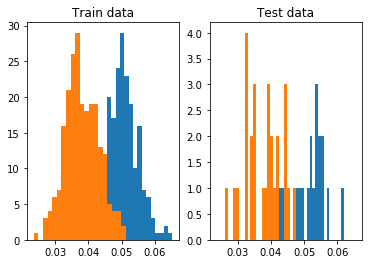

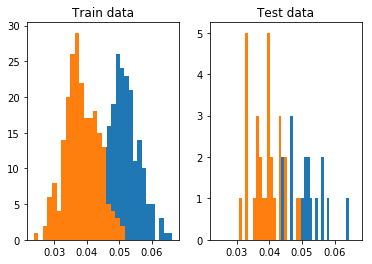

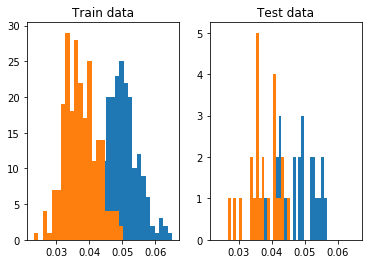

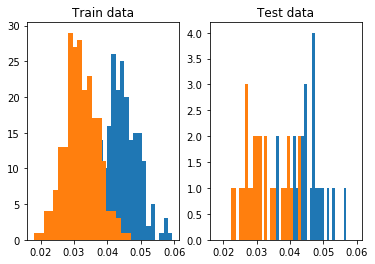

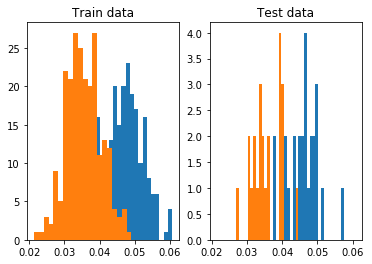

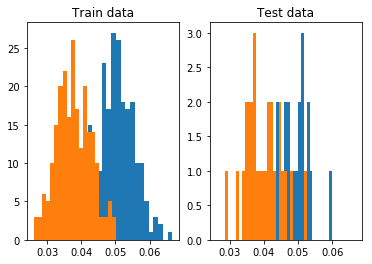

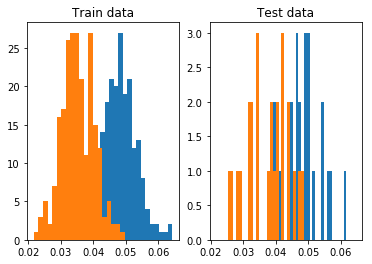

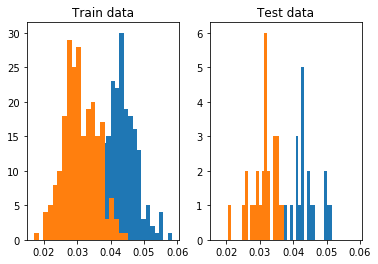

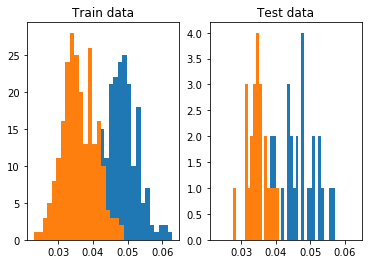

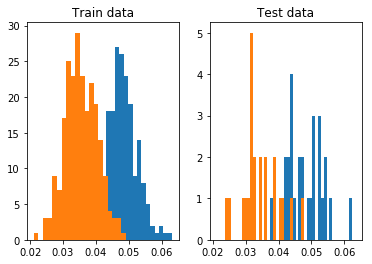

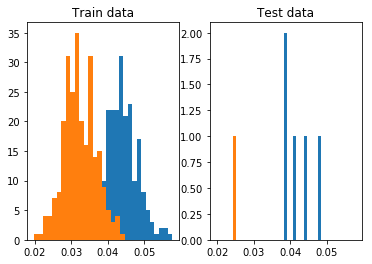

In [10]:
LDA1dProjection('boston.csv', 10)